# Example: Tapqir output files (Part 2)

This tutorial is a Jupyter notebook that illustrates how to load & open output files from Tapqir analysis. To work with the live version of the notebook run it in Google Colab using the link above.

## Set up & Installation on Google Colab

* Run the cell below to install Tapqir in Google Colab (takes about a minute):

In [1]:
# Run this cell to install Tapqir in Google Colab
!pip install --quiet git+https://github.com/gelles-brandeis/tapqir.git > install.log

* Connect Google Drive to be able to load output files from Tapqir analysis in Part 1:

In [2]:
# Run this cell to connect to Google Drive
from google.colab import drive

drive.mount("/content/drive")
# change directory to Rpb1SNAP549 folder
%cd drive/MyDrive/Rpb1SNAP549

Mounted at /content/drive
/content/drive/MyDrive/Rpb1SNAP549


## Data file

After processing raw input data (`tapqir glimpse` command) Tapqir stores processed data in a `data.tpqr` file.

In [3]:
# import load function that loads Tapqir data files
from tapqir.utils.dataset import load

In [4]:
# we load data from current directory ("."). Tapqir will automatically look for data.tpqr file in this directory
data = load(".")

In [5]:
data

CosmosDataset: Rpb1SNAP549
  ontarget.images  tensor(N=331 AOIs, F=862 frames, P=14 pixels, P=14 pixels)
          .x       tensor(N=331 AOIs, F=862 frames)
          .y       tensor(N=331 AOIs, F=862 frames)

  offtarget.images tensor(N=526 AOIs, F=862 frames, P=14 pixels, P=14 pixels)
           .x      tensor(N=526 AOIs, F=862 frames)
           .y      tensor(N=526 AOIs, F=862 frames)

  offset.samples   tensor([ 94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
                          108, 109, 110, 111, 112, 113, 114, 115, 116, 117])
        .weights   tensor([0.0097, 0.0215, 0.0486, 0.0911, 0.1323, 0.1651, 0.1526, 0.1043, 0.0775,
                          0.0521, 0.0355, 0.0221, 0.0190, 0.0159, 0.0124, 0.0085, 0.0070, 0.0057,
                          0.0044, 0.0030, 0.0026, 0.0022, 0.0017, 0.0054])

Data is stored as a `CosmosDataset` object that has a title (`Rpb1SNAP549`), `ontarget` attribute for on-target data, `offtarget` attribute for off-target control data, and `offset` attribute for camera offset data.

`ontarget` and `offtarget` are `CosmosData` objects that have `images` attribute for AOI images (torch.Tensor with `(N, F, P, P)` shape), `x` attribute for target locations on the _x_-axis (torch.Tensor with `(N, F)` shape), and `y` attribute for target locations on the _y_-axis (torch.Tensor with `(N, F)` shape). As an example we will plot frames 625, 628, 630, 633, 635, 638, 640, 643, 645 from AOI 163 and also show target locations (red + sign).

In [11]:
# import matplotlib for plotting
import matplotlib.pyplot as plt

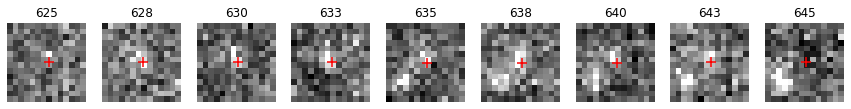

In [31]:
fig = plt.figure(figsize=(15, 1.5))
n = 163  # AOI
frames = [625, 628, 630, 633, 635, 638, 640, 643, 645]

for i, f in enumerate(frames):
    ax = fig.add_subplot(1, 9, i + 1)
    ax.imshow(data.ontarget.images[n, f].numpy(), vmin=340, vmax=635, cmap="gray")
    ax.scatter(
        data.ontarget.x[n, f].item(),
        data.ontarget.y[n, f].item(),
        c="r",
        s=100,
        marker="+",
    )
    ax.set_title(f, fontsize=12)
    ax.axis("off")

`offset` is an `OffsetData` object that has `samples` attribute for camera offset values and `weights` attribute for their probabilities (together they define and Empirical distribution for the offset signal). Let's plot it.

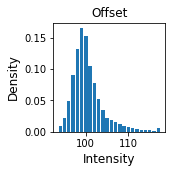

In [30]:
plt.figure(figsize=(2, 2))
plt.bar(data.offset.samples, data.offset.weights)
plt.title("Offset", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.xlabel("Intensity", fontsize=12)
plt.show()

## Parameters file

Model parameters with 95% CI (credible interval) are stored in `cosmos-params.tpqr` file (nested dictionary of `torch.Tensor`s). Let's load it first.

In [33]:
import torch

In [34]:
params = torch.load("cosmos-params.tpqr")

In [37]:
# list all parameters
params.keys()

dict_keys(['gain', 'proximity', 'lamda', 'pi', 'Keq', 'd/height', 'd/width', 'd/x', 'd/y', 'd/background', 'd/m_probs', 'd/z_probs', 'd/j_probs', 'p(specific)', 'z_map'])

- `gain` - $g$ camera gain
- `proximity` - $\sigma^{xy}$ proximity
- `lamda` - $\lambda$ off-target binding rate
- `pi` - $\pi$ average on-target binding probability
- `Keq` - equilibrium constant calculated as $\frac{\pi}{1-\pi}$

Below prefix `d/` stands for on-target data.

- `p(specific)` - $p(\mathsf{specific})$ probability of there being any target-specific spot in an AOI image
- `z_map` - most likely value (0 or 1) for target-specific spot presence (obtained from $p(\mathsf{specific})$ using 0.5 cutoff)
- `d/theta_probs` - $p(\theta|D)$ target-specific spot index probabilities
- `d/m_probs` - $p(m|D)$ spot presence probabilities
- `d/j_probs` - $p(\theta|D) - p(m|D)$ nonspecific spot presence probabilities
- `d/height` - $h$ spot intensity
- `d/width` - $w$ spot width
- `d/x` - $x$ spot position on _x_-axis
- `d/y` - $y$ spot position on _y_-axis
- `d/background` - $b$ background intensity


For example, let's look at gain $g$:

In [39]:
params["gain"]

{'LL': tensor(6.5673, dtype=torch.float64),
 'Mean': tensor(6.5687, dtype=torch.float64),
 'UL': tensor(6.5700, dtype=torch.float64)}

It is a dictionary with `Mean` (6.5687), 95% CI lower-limit `LL` (6.5673) and upper-limit `UL` (6.5700) entries.

Let's plot $p(\mathsf{specific})$ for AOI 163 and frames from 625 to 645:

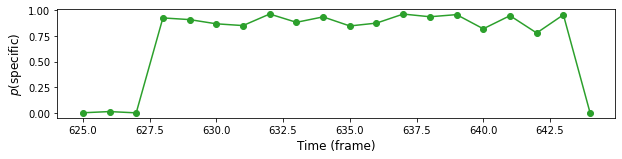

In [44]:
n = 163
f1, f2 = 625, 645

plt.figure(figsize=(10, 2))
plt.plot(torch.arange(f1, f2), params["p(specific)"][n, f1:f2], "o-", color="C2")
plt.ylabel(r"$p(\mathsf{specific})$", fontsize=12)
plt.xlabel("Time (frame)", fontsize=12)
plt.show()

To plot credible intervals we can use `pyplot`'s `fill_between` method. Here is the plot of intensity $h$ for spot 1 in the same range of frames:

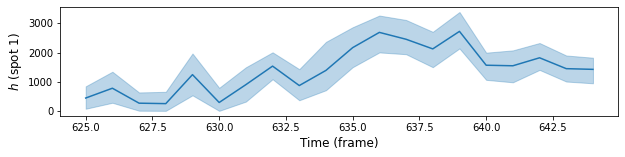

In [51]:
k = 0  # spot 1
n = 163  # AOI
f1, f2 = 625, 645  # frame range

plt.figure(figsize=(10, 2))
plt.plot(torch.arange(f1, f2), params["d/height"]["Mean"][k, n, f1:f2], "-", color="C0")
plt.fill_between(
    torch.arange(f1, f2),
    params["d/height"]["LL"][k, n, f1:f2],
    params["d/height"]["UL"][k, n, f1:f2],
    color="C0",
    alpha=0.3,
)
plt.ylabel(r"$h$ (spot 1)", fontsize=12)
plt.xlabel("Time (frame)", fontsize=12)
plt.show()

### Probabilistic rastergram

We can plot $p(\mathsf{specific})$ as a probabilistic rastergram.

In [54]:
import matplotlib as mpl

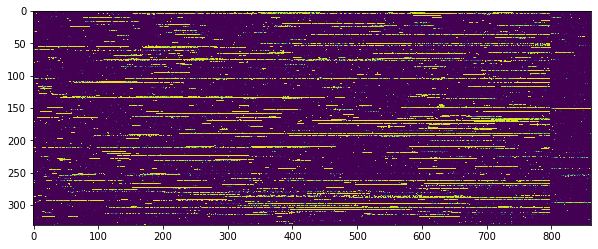

In [57]:
plt.figure(figsize=(10, 5))
plt.imshow(
    params["p(specific)"],
    norm=mpl.colors.Normalize(vmin=0, vmax=1),
    aspect="equal",
    interpolation="none",
)
plt.show()

### Global parameters

`statistics.csv` file contains values of global parameters (for easy access). In python we can load it using `pandas` module. 

In [52]:
import pandas as pd

In [53]:
stats = pd.read_csv("statistics.csv", index_col=0)
stats

,Mean,95% LL,95% UL
gain,6.568741,6.567314,6.570015
proximity,0.562996,0.559636,0.566373
lamda,0.302736,0.301361,0.304205
pi,0.101984,0.100589,0.103377
Keq,0.113566,0.111825,0.115282
SNR,1.626540,NaN,NaN
